In [115]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('model_matchups_weekend2_classic_historical.csv')
print(df.shape)
df.head()

(180, 80)


,game_id,id,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,high_bracket_score,...,d_b,d_c,d_d,d_f,f_s,f_a,f_b,f_c,f_d,f_f
0,20083113,3113,2008,East,Sweet 16,1,2008 North Carolina,4,2008 Washington St.,68,...,0,0,0,0,0,0,0,0,0,0
1,20084115,4115,2008,East,Elite Eight,1,2008 North Carolina,3,2008 Louisville,83,...,0,0,0,0,0,0,0,0,0,0
2,20083113,3113,2008,East,Sweet 16,3,2008 Louisville,2,2008 Tennessee,79,...,0,0,0,0,0,0,0,0,0,0
3,20083213,3213,2008,Midwest,Sweet 16,1,2008 Kansas,12,2008 Villanova,72,...,0,0,0,0,0,0,0,0,0,0
4,20084215,4215,2008,Midwest,Elite Eight,1,2008 Kansas,10,2008 Davidson,59,...,0,0,0,0,0,0,0,0,0,0


In [116]:
df.columns.to_list()

['game_id',
 'id',
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'high_bracket_score',
 'low_bracket_score',
 'point_diff',
 'point_total',
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f',
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f',
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f',
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f',
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']

In [117]:
df['win'].value_counts()

1    107
0     73
Name: win, dtype: int64

# I. Check Tiers

In [118]:
s_tiers = df[[
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f']]
print(s_tiers.value_counts())
a_tiers = df[[
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f']]
print(a_tiers.value_counts())
b_tiers = df[[
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f']]
print(b_tiers.value_counts())
c_tiers = df[[
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f']]
print(c_tiers.value_counts())
d_tiers = df[[
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f']]
print(d_tiers.value_counts())
f_tiers = df[[
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']]
print(f_tiers.value_counts())

s_s  s_a  s_b  s_c  s_d  s_f
0    0    0    0    0    0      94
               1    0    0      28
          1    0    0    0      21
     1    0    0    0    0      20
1    0    0    0    0    0      15
0    0    0    0    1    0       2
dtype: int64
a_s  a_a  a_b  a_c  a_d  a_f
0    0    0    0    0    0      159
1    0    0    0    0    0        8
0    0    0    1    0    0        5
          1    0    0    0        4
     1    0    0    0    0        4
dtype: int64
b_s  b_a  b_b  b_c  b_d  b_f
0    0    0    0    0    0      159
     1    0    0    0    0        6
     0    0    1    0    0        5
1    0    0    0    0    0        5
0    0    1    0    0    0        3
          0    0    0    1        1
                    1    0        1
dtype: int64
c_s  c_a  c_b  c_c  c_d  c_f
0    0    0    0    0    0      130
               1    0    0       13
1    0    0    0    0    0       13
0    1    0    0    0    0       12
     0    1    0    0    0        8
          0    0    1  

In [119]:
# Remove all tier matchups that happened three or less times and view win percentage of the the remaining tiers
all_tiers = df[[
 'win',
 's_s',
 's_a',
 's_b',
 's_c',
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 ]]

In [120]:
all_tiers.groupby(by=['win', 's_s']).size()

win  s_s
0    0      66
     1       7
1    0      99
     1       8
dtype: int64

In [121]:
all_tiers.groupby(by=['win', 's_a']).size()

win  s_a
0    0      64
     1       9
1    0      96
     1      11
dtype: int64

In [122]:
all_tiers.groupby(by=['win', 's_b']).size()

win  s_b
0    0      68
     1       5
1    0      91
     1      16
dtype: int64

In [123]:
all_tiers.groupby(by=['win', 's_c']).size()

win  s_c
0    0      67
     1       6
1    0      85
     1      22
dtype: int64

In [124]:
all_tiers.groupby(by=['win', 'a_s']).size()

win  a_s
0    0       68
     1        5
1    0      104
     1        3
dtype: int64

In [125]:
all_tiers.groupby(by=['win', 'a_a']).size()

win  a_a
0    0       69
     1        4
1    0      107
dtype: int64

In [126]:
all_tiers.groupby(by=['win', 'a_b']).size()

win  a_b
0    0       72
     1        1
1    0      104
     1        3
dtype: int64

In [127]:
all_tiers.groupby(by=['win', 'a_c']).size()

win  a_c
0    0       73
1    0      102
     1        5
dtype: int64

In [128]:
all_tiers.groupby(by=['win', 'b_s']).size()

win  b_s
0    0       71
     1        2
1    0      104
     1        3
dtype: int64

In [129]:
all_tiers.groupby(by=['win', 'b_a']).size()

win  b_a
0    0       69
     1        4
1    0      105
     1        2
dtype: int64

In [130]:
all_tiers.groupby(by=['win', 'b_b']).size()

win  b_b
0    0       72
     1        1
1    0      105
     1        2
dtype: int64

In [131]:
all_tiers.groupby(by=['win', 'b_c']).size()

win  b_c
0    0       72
     1        1
1    0      103
     1        4
dtype: int64

In [132]:
all_tiers.groupby(by=['win', 'c_s']).size()

win  c_s
0    0       65
     1        8
1    0      102
     1        5
dtype: int64

In [133]:
all_tiers.groupby(by=['win', 'c_d']).size()

win  c_d
0    0       72
     1        1
1    0      105
     1        2
dtype: int64

In [134]:
# Remove any tier with win percentages under 67% and greater than 33% and keep only columns that can be included in a model
eda_df = df[[
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_b',
 's_c',
 'a_b',
 'a_c',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'c_d',
 ]]
eda_df.shape

(180, 40)

In [135]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape

((144, 39), (36, 39))

In [136]:
y_train.shape, y_test.shape

((144,), (36,))

In [137]:
X_train.head()

,ovr_rating_bpi,ovr_rating_kenpom,ovr_rating_torvik,wab,off_rating_bpi,off_rating_kenpom,off_rating_torvik,def_rating_bpi,def_rating_kenpom,def_rating_torvik,...,adj_tempo,s_b,s_c,a_b,a_c,b_s,b_a,b_b,b_c,c_d
55,-2.0000,-4.3931,-0.0246,3.0975,0.4000,2.1349,-1.5597,-2.4000,-7.2289,-4.5500,...,-1.0000,0,0,0,0,0,0,0,0,0
83,-1.2000,-1.0319,0.0055,-7.3342,-1.9000,14.7768,15.8805,0.7000,-15.3501,-16.1170,...,-0.2000,0,0,0,0,0,0,0,0,0
45,-4.9000,-4.5310,-0.0525,-5.6113,-1.5000,7.0425,5.3995,-3.4000,-11.7568,-9.7360,...,1.6000,0,0,0,0,0,0,0,0,0
163,-6.2000,-8.4626,-0.0664,-7.1244,0.8000,7.6423,6.3276,-6.8000,-16.4877,-13.7039,...,3.3000,0,0,0,0,0,0,0,0,0
123,-3.9000,-8.9113,-0.0715,-3.9024,0.3000,10.6575,9.1806,-4.1000,-19.8224,-16.3083,...,3.2000,0,0,0,0,0,0,0,0,0


In [138]:
X_train.columns.to_list()

['ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_b',
 's_c',
 'a_b',
 'a_c',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'c_d']

# II. Box Plots

<Axes: xlabel='win', ylabel='ovr_rating_bpi'>

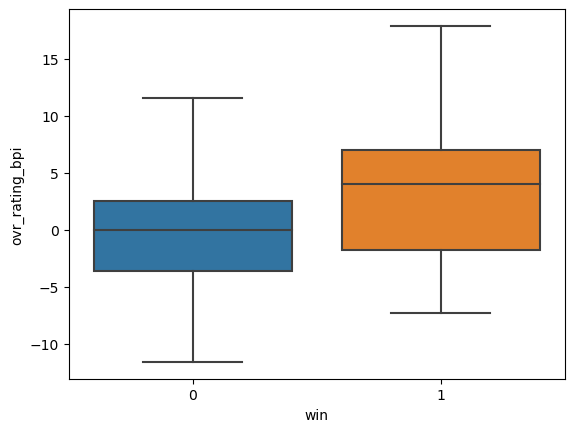

In [139]:
sns.boxplot(data=df, x='win', y='ovr_rating_bpi')

<Axes: xlabel='win', ylabel='ovr_rating_kenpom'>

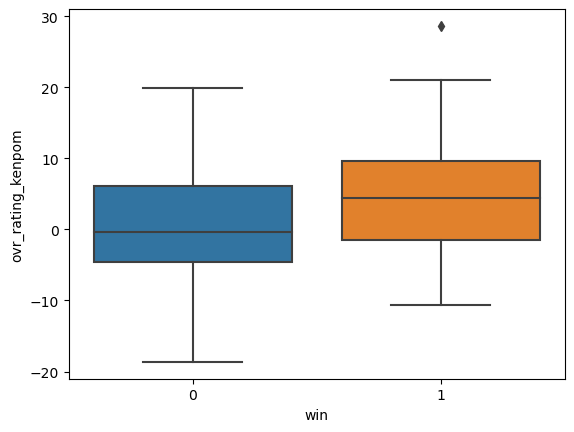

In [140]:
sns.boxplot(data=df, x='win', y='ovr_rating_kenpom')

<Axes: xlabel='win', ylabel='ovr_rating_torvik'>

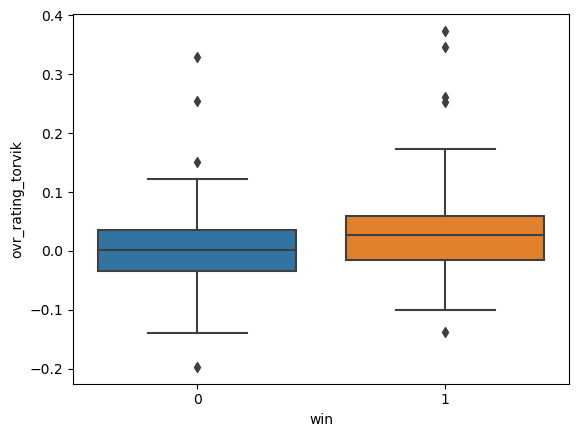

In [141]:
sns.boxplot(data=df, x='win', y='ovr_rating_torvik')

<Axes: xlabel='win', ylabel='wab'>

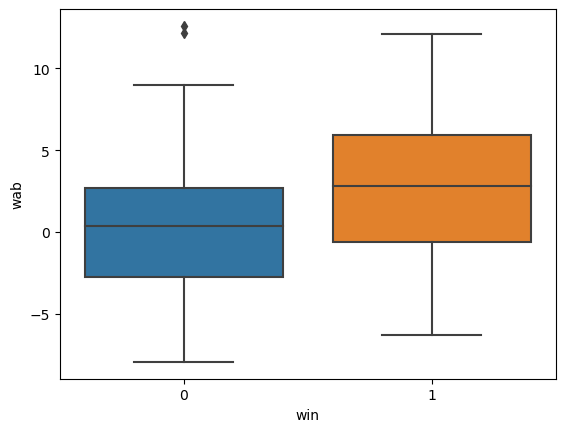

In [142]:
sns.boxplot(data=df, x='win', y='wab')

<Axes: xlabel='win', ylabel='off_rating_bpi'>

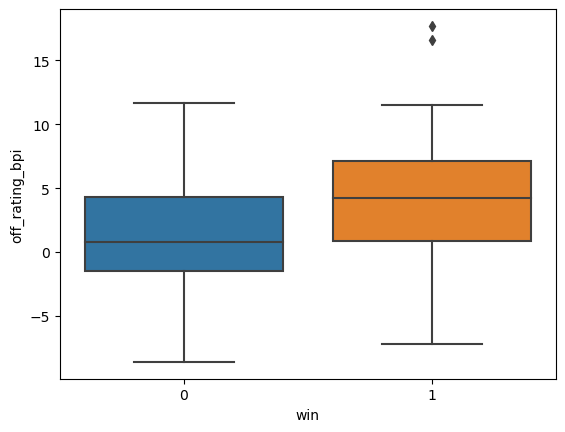

In [143]:
sns.boxplot(data=df, x='win', y='off_rating_bpi')

<Axes: xlabel='win', ylabel='off_rating_kenpom'>

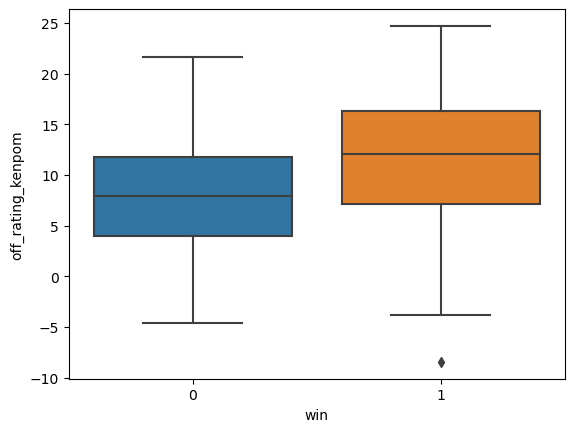

In [144]:
sns.boxplot(data=df, x='win', y='off_rating_kenpom')

<Axes: xlabel='win', ylabel='off_rating_torvik'>

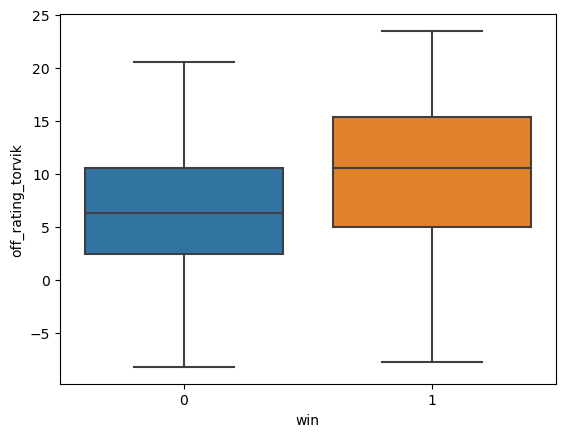

In [145]:
sns.boxplot(data=df, x='win', y='off_rating_torvik')

<Axes: xlabel='win', ylabel='def_rating_bpi'>

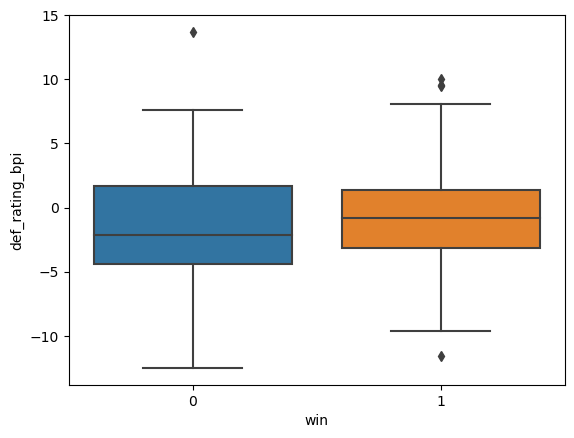

In [146]:
sns.boxplot(data=df, x='win', y='def_rating_bpi')

<Axes: xlabel='win', ylabel='def_rating_kenpom'>

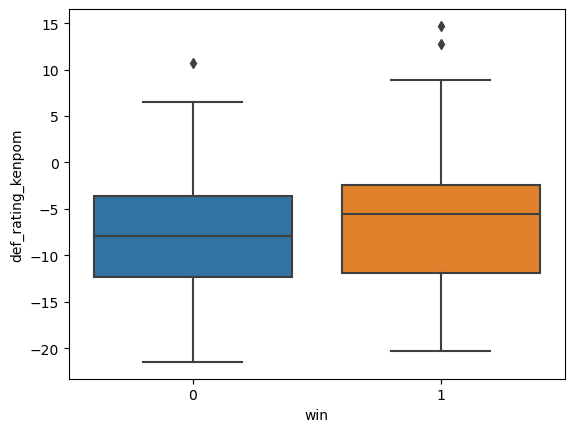

In [147]:
sns.boxplot(data=df, x='win', y='def_rating_kenpom')

<Axes: xlabel='win', ylabel='def_rating_torvik'>

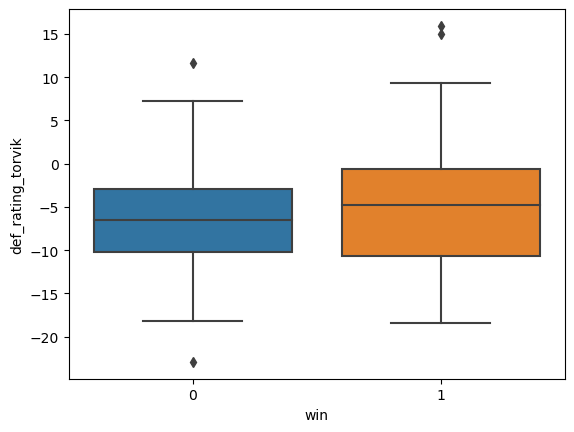

In [148]:
sns.boxplot(data=df, x='win', y='def_rating_torvik')

<Axes: xlabel='win', ylabel='efg%_off'>

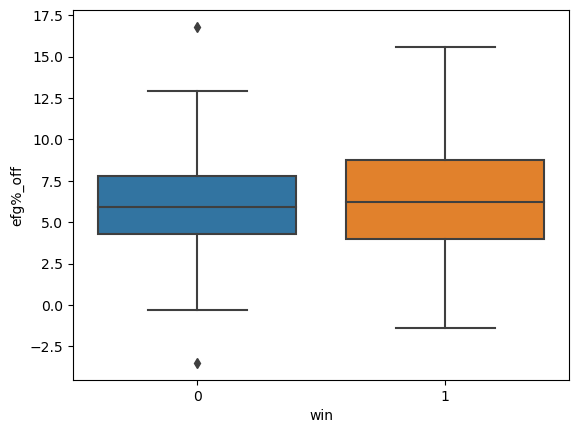

In [149]:
sns.boxplot(data=df, x='win', y='efg%_off')

<Axes: xlabel='win', ylabel='ftr_off'>

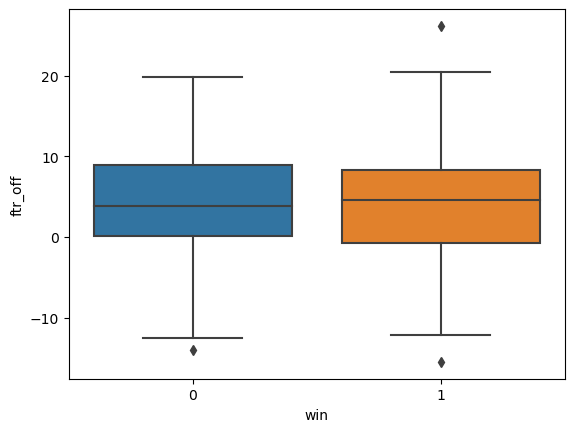

In [150]:
sns.boxplot(data=df, x='win', y='ftr_off')

<Axes: xlabel='win', ylabel='reb%_off'>

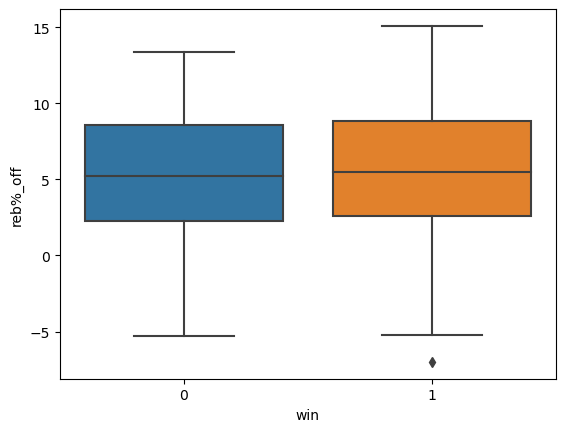

In [151]:
sns.boxplot(data=df, x='win', y='reb%_off')

<Axes: xlabel='win', ylabel='to%_off'>

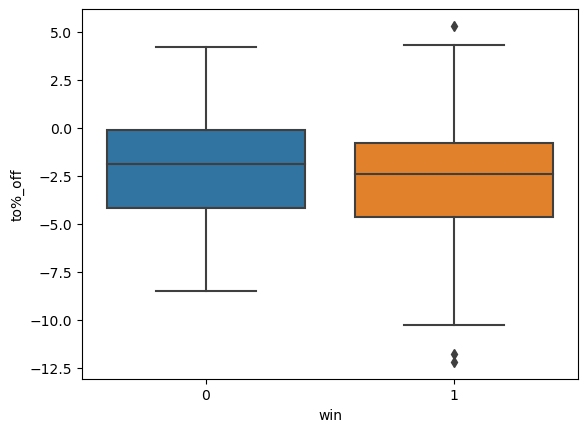

In [152]:
sns.boxplot(data=df, x='win', y='to%_off')

<Axes: xlabel='win', ylabel='efg%_def'>

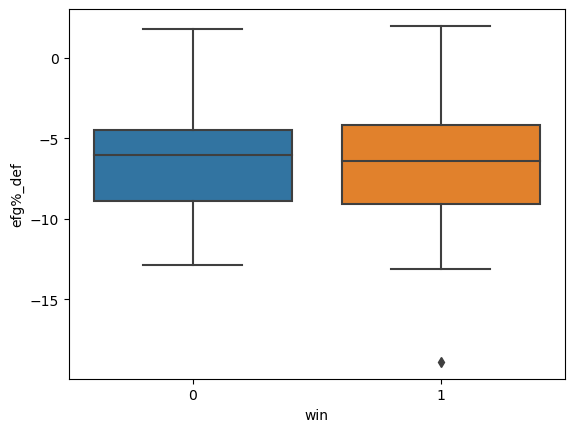

In [153]:
sns.boxplot(data=df, x='win', y='efg%_def')

<Axes: xlabel='win', ylabel='ftr_def'>

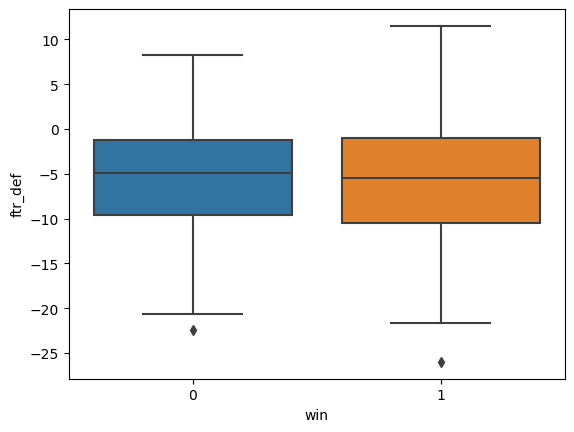

In [154]:
sns.boxplot(data=df, x='win', y='ftr_def')

<Axes: xlabel='win', ylabel='reb%_def'>

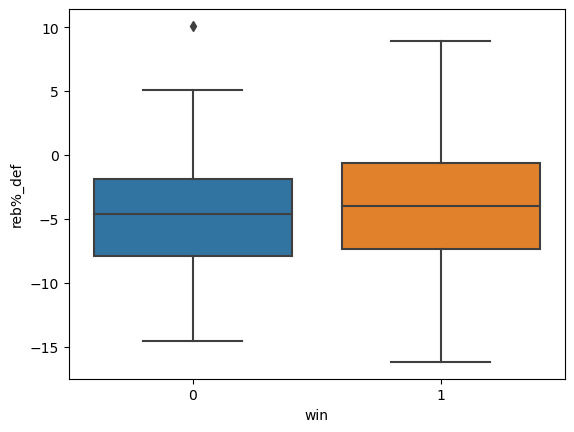

In [155]:
sns.boxplot(data=df, x='win', y='reb%_def')

<Axes: xlabel='win', ylabel='to%_def'>

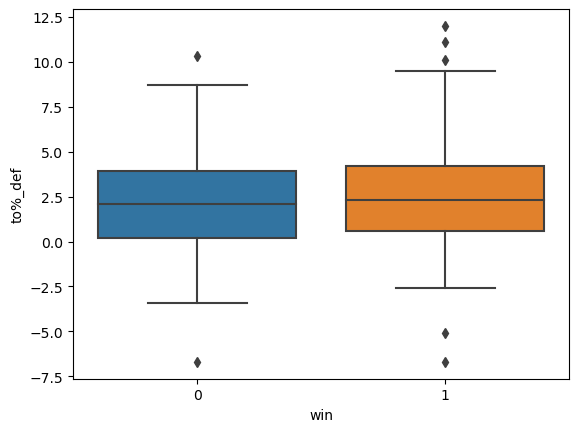

In [156]:
sns.boxplot(data=df, x='win', y='to%_def')

<Axes: xlabel='win', ylabel='2p%_off'>

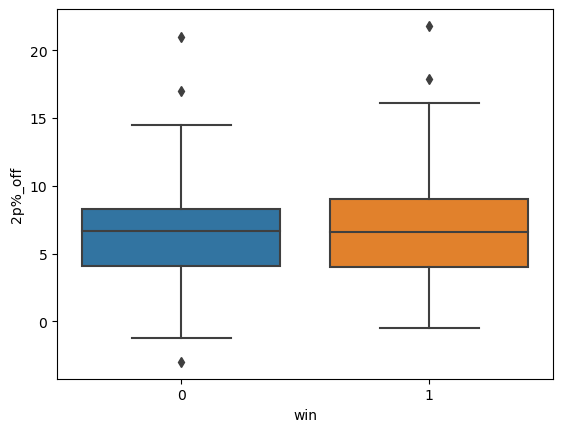

In [157]:
sns.boxplot(data=df, x='win', y='2p%_off')

<Axes: xlabel='win', ylabel='3p%_off'>

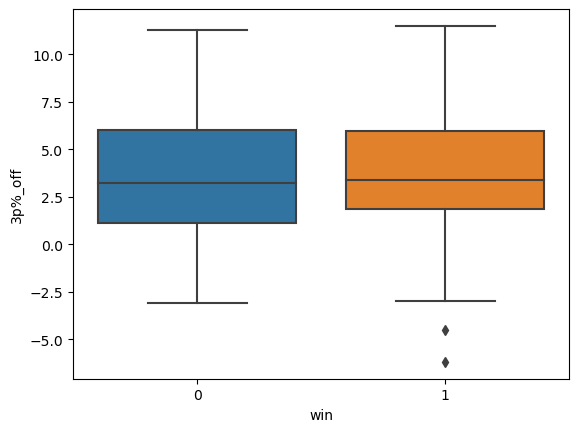

In [158]:
sns.boxplot(data=df, x='win', y='3p%_off')

<Axes: xlabel='win', ylabel='eff_off'>

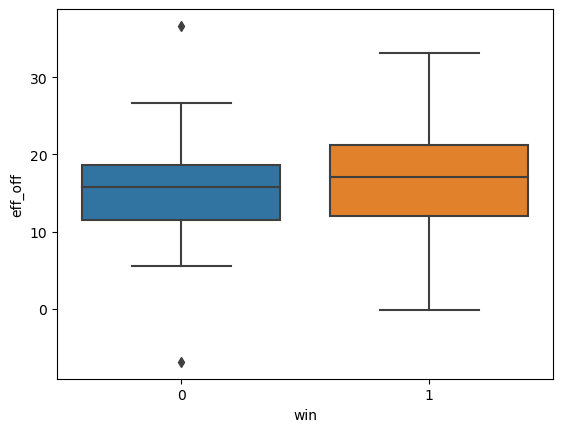

In [159]:
sns.boxplot(data=df, x='win', y='eff_off')

<Axes: xlabel='win', ylabel='ft%_off'>

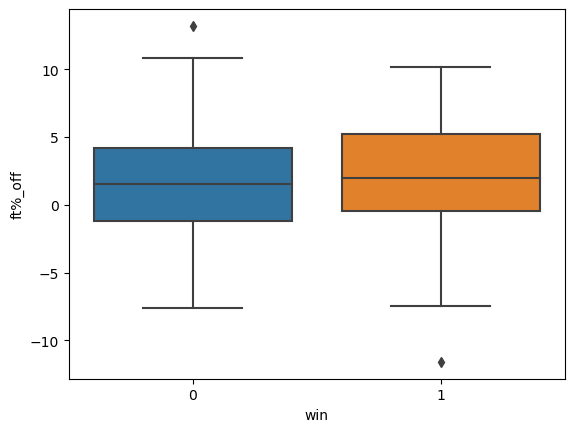

In [160]:
sns.boxplot(data=df, x='win', y='ft%_off')

<Axes: xlabel='win', ylabel='2p%_def'>

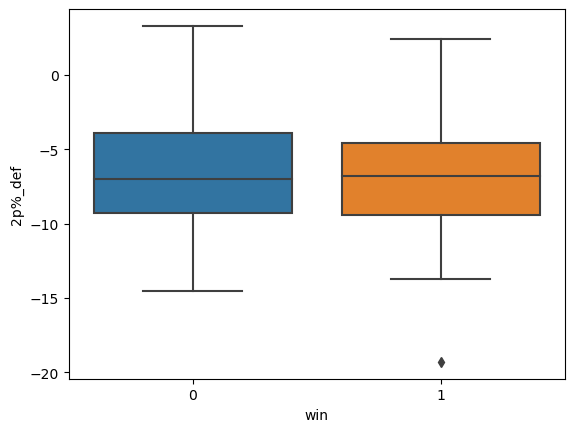

In [161]:
sns.boxplot(data=df, x='win', y='2p%_def')

<Axes: xlabel='win', ylabel='3p%_def'>

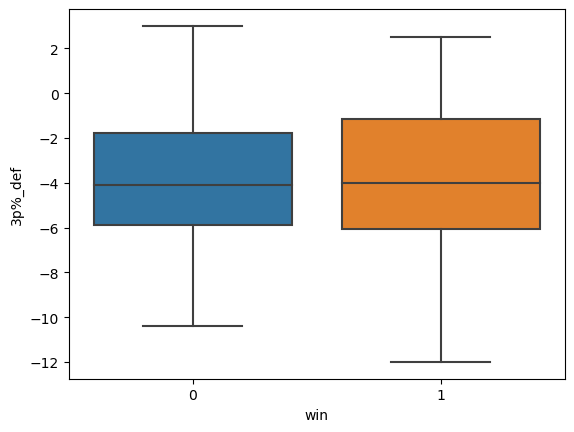

In [162]:
sns.boxplot(data=df, x='win', y='3p%_def')

<Axes: xlabel='win', ylabel='eff_def'>

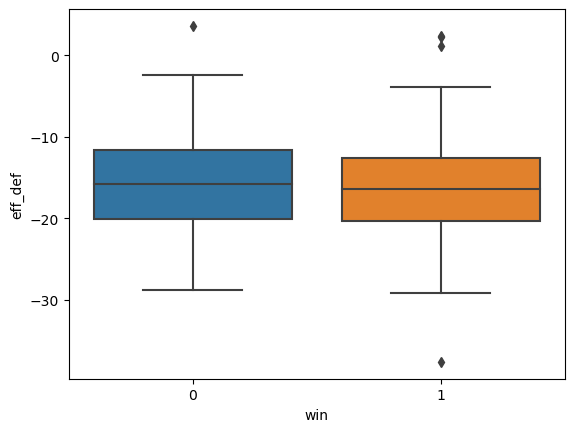

In [163]:
sns.boxplot(data=df, x='win', y='eff_def')

<Axes: xlabel='win', ylabel='ft%_def'>

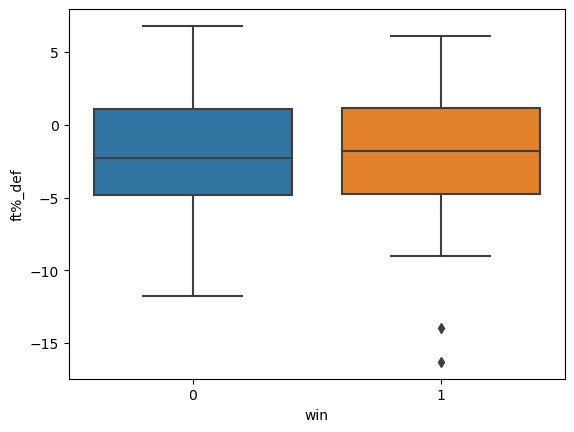

In [164]:
sns.boxplot(data=df, x='win', y='ft%_def')

<Axes: xlabel='win', ylabel='height_eff'>

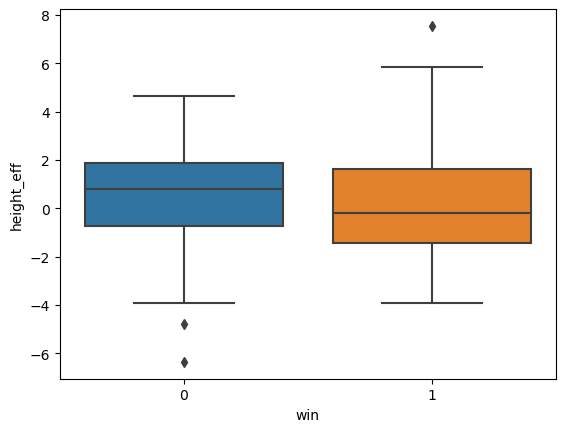

In [165]:
sns.boxplot(data=df, x='win', y='height_eff')

<Axes: xlabel='win', ylabel='size'>

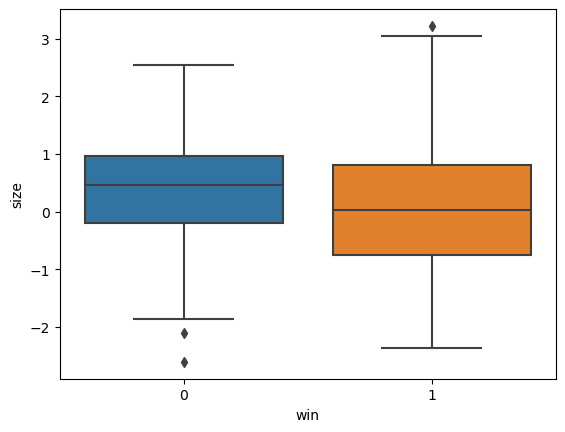

In [166]:
sns.boxplot(data=df, x='win', y='size')

<Axes: xlabel='win', ylabel='bench'>

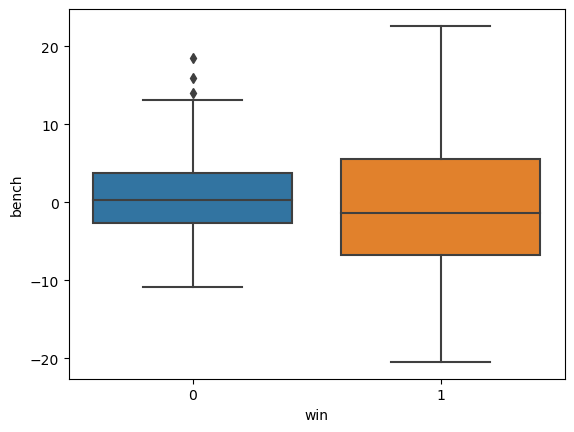

In [167]:
sns.boxplot(data=df, x='win', y='bench')

<Axes: xlabel='win', ylabel='adj_tempo'>

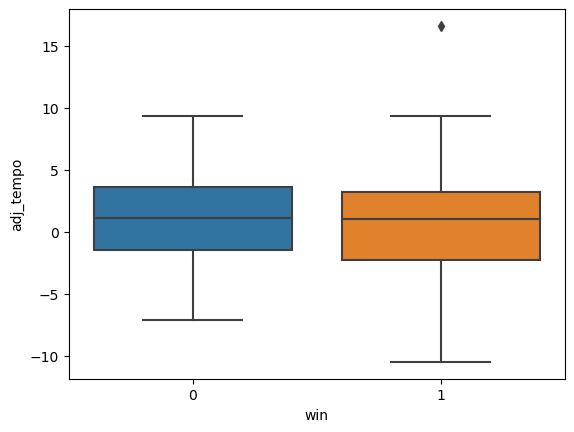

In [168]:
sns.boxplot(data=df, x='win', y='adj_tempo')

# III. Mutual Information

Text(0, 0.5, 'Mutual Information')

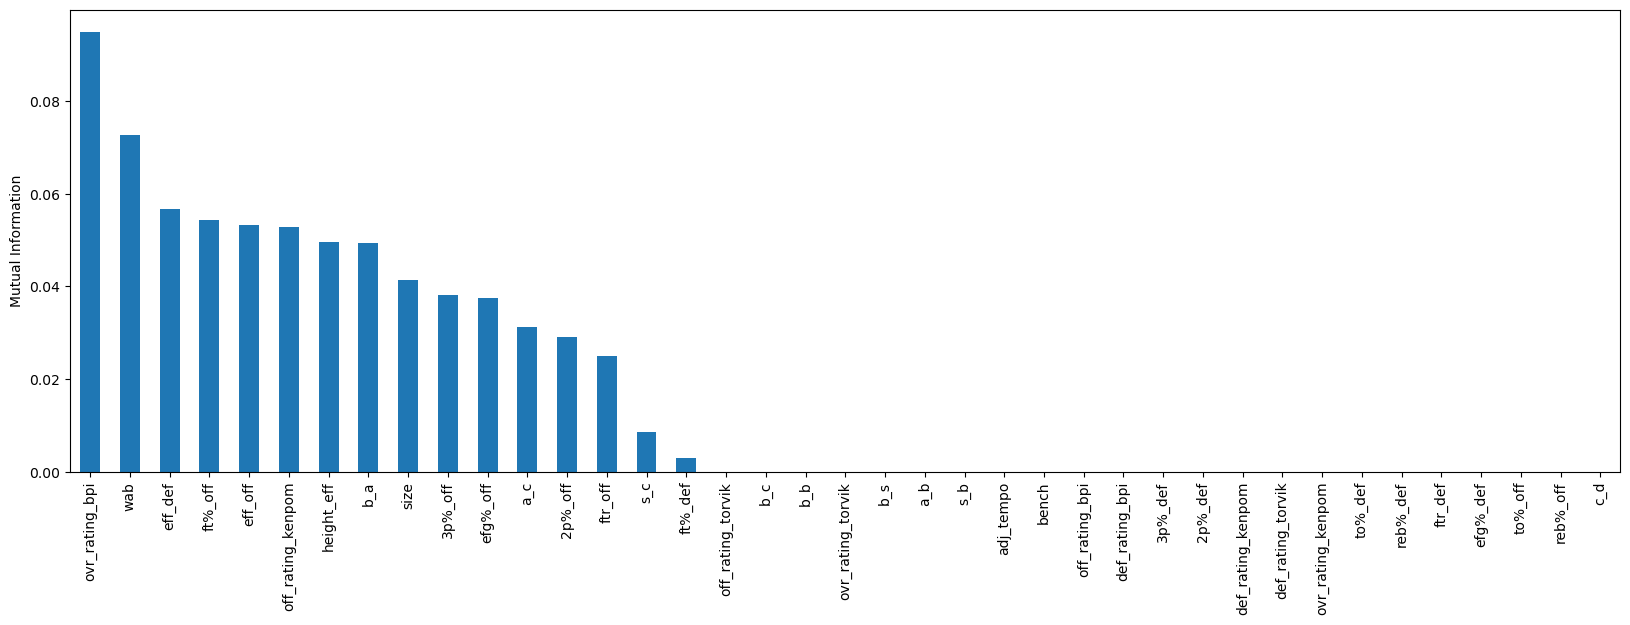

In [169]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [170]:
mi

ovr_rating_bpi      0.0950
ovr_rating_kenpom   0.0000
ovr_rating_torvik   0.0000
wab                 0.0727
off_rating_bpi      0.0000
off_rating_kenpom   0.0528
off_rating_torvik   0.0000
def_rating_bpi      0.0000
def_rating_kenpom   0.0000
def_rating_torvik   0.0000
efg%_off            0.0374
ftr_off             0.0249
reb%_off            0.0000
to%_off             0.0000
efg%_def            0.0000
ftr_def             0.0000
reb%_def            0.0000
to%_def             0.0000
2p%_off             0.0291
3p%_off             0.0381
eff_off             0.0532
ft%_off             0.0544
2p%_def             0.0000
3p%_def             0.0000
eff_def             0.0567
ft%_def             0.0029
height_eff          0.0496
size                0.0413
bench               0.0000
adj_tempo           0.0000
s_b                 0.0000
s_c                 0.0086
a_b                 0.0000
a_c                 0.0313
b_s                 0.0000
b_a                 0.0494
b_b                 0.0000
b

In [171]:
sel_ = SelectKBest(f_classif, k=8).fit(X_train, y_train)
X_train.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'off_rating_bpi', 'off_rating_kenpom', 'off_rating_torvik', 's_b'],
      dtype='object')

# IV. ANOVA

In [172]:
X_num = X_train[[
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo']]

X_cat = X_train[[
    's_b',
    's_c',
    'a_b',
    'a_c',
    'b_s',
    'b_a',
    'b_b',
    'b_c',
    'c_d']]

<Axes: >

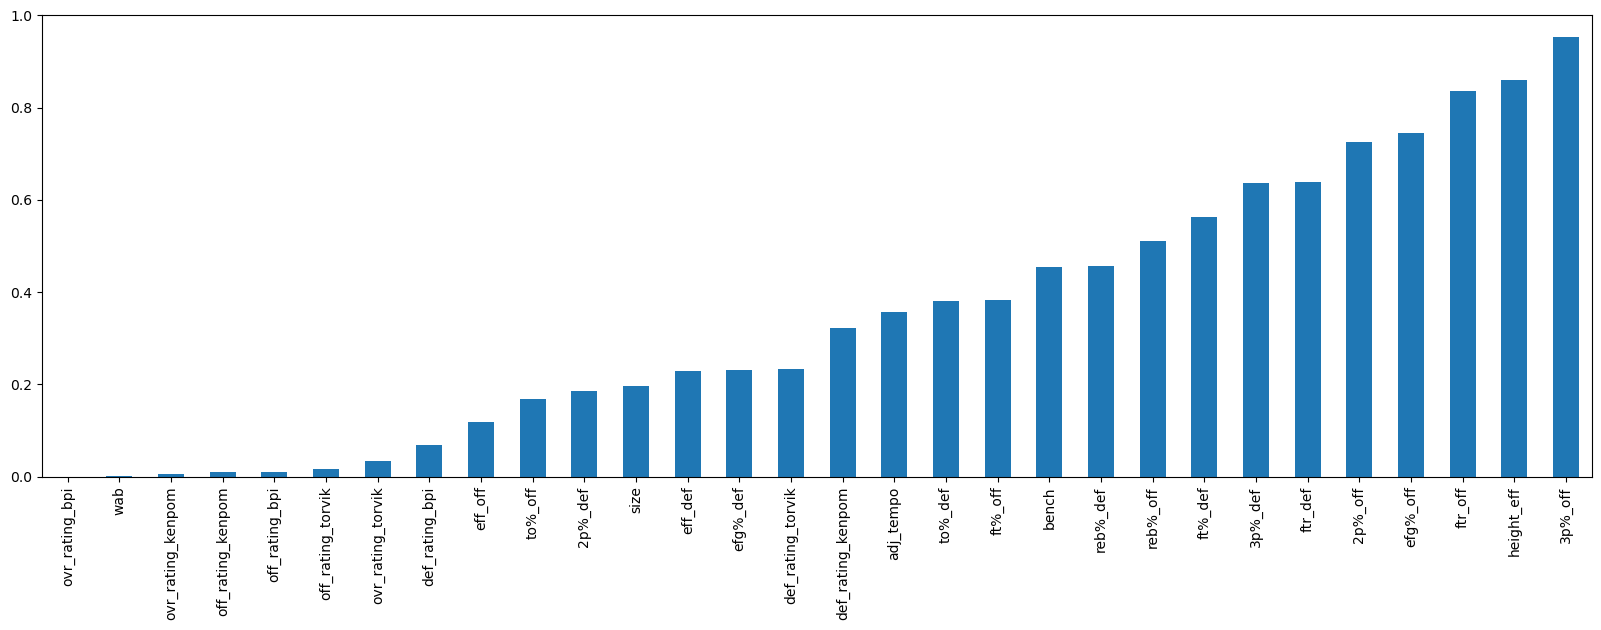

In [173]:
univariate = f_classif(X_num, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_num.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6))

In [174]:
univariate

ovr_rating_bpi      0.0002
ovr_rating_kenpom   0.0051
ovr_rating_torvik   0.0330
wab                 0.0004
off_rating_bpi      0.0099
off_rating_kenpom   0.0095
off_rating_torvik   0.0164
def_rating_bpi      0.0687
def_rating_kenpom   0.3227
def_rating_torvik   0.2328
efg%_off            0.7457
ftr_off             0.8364
reb%_off            0.5101
to%_off             0.1693
efg%_def            0.2319
ftr_def             0.6399
reb%_def            0.4567
to%_def             0.3817
2p%_off             0.7258
3p%_off             0.9540
eff_off             0.1185
ft%_off             0.3835
2p%_def             0.1854
3p%_def             0.6378
eff_def             0.2301
ft%_def             0.5620
height_eff          0.8600
size                0.1971
bench               0.4554
adj_tempo           0.3565
dtype: float64

In [175]:
sel_ = SelectKBest(f_classif, k=8).fit(X_num, y_train)
X_num.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'off_rating_bpi', 'off_rating_kenpom', 'off_rating_torvik',
       'def_rating_bpi'],
      dtype='object')

# V. Chi Squared

In [176]:
chi_ls = []

for feature in X_cat.columns:
    c = pd.crosstab(y_train, X_cat[feature])
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

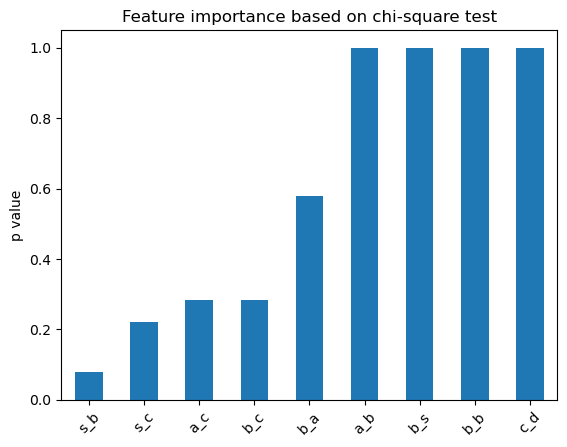

In [177]:
pd.Series(chi_ls, index=X_cat.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [178]:
chi_ls

[0.08006159173488914,
 0.22056115899223439,
 1.0,
 0.28341203793863345,
 1.0,
 0.5802579256998612,
 1.0,
 0.28341203793863345,
 1.0]

# VI. Lasso Regression

In [179]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [180]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [181]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 39
selected features: 25
features with coefficients shrank to zero: 14


In [182]:
selected_feat

Index(['ovr_rating_bpi', 'ovr_rating_torvik', 'wab', 'def_rating_bpi',
       'def_rating_kenpom', 'ftr_off', 'reb%_off', 'to%_off', 'reb%_def',
       'to%_def', '3p%_off', 'eff_off', 'ft%_off', '2p%_def', 'ft%_def',
       'size', 'bench', 'adj_tempo', 's_b', 's_c', 'a_c', 'b_a', 'b_b', 'b_c',
       'c_d'],
      dtype='object')

# VII. Backward Selection

In [183]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=11,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [184]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [185]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['ovr_rating_bpi', 'ovr_rating_torvik', 'wab', 'off_rating_bpi',
       'off_rating_kenpom', 'off_rating_torvik', 'efg%_def', '2p%_def',
       'bench', 'adj_tempo', 'a_b'], dtype=object)

In [186]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9270684371807968
Test set
Random Forests roc-auc: 0.7438271604938271


In [187]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9585291113381
Test set
Random Forests roc-auc: 0.7438271604938271


In [188]:
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
rf.fit(X_train, y_train)

print('Train set')
pred = rf.predict_proba(X_train)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
print('Test set')
pred = rf.predict_proba(X_test)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set
Random Forests roc-auc: 0.9585291113381
Test set
Random Forests roc-auc: 0.7438271604938271


In [189]:
rf.feature_importances_

array([0.0724, 0.0375, 0.0329, 0.0879, 0.0454, 0.0647, 0.0564, 0.0502,
       0.0247, 0.0180, 0.0244, 0.0100, 0.0197, 0.0225, 0.0194, 0.0222,
       0.0201, 0.0235, 0.0101, 0.0143, 0.0210, 0.0299, 0.0279, 0.0141,
       0.0417, 0.0218, 0.0307, 0.0657, 0.0375, 0.0263, 0.0037, 0.0009,
       0.0000, 0.0000, 0.0002, 0.0021, 0.0000, 0.0000, 0.0000])

# IX. ROC-AUC

In [190]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5740740740740741,
 0.5277777777777778,
 0.4722222222222222,
 0.6666666666666667,
 0.49691358024691357,
 0.4166666666666667,
 0.3611111111111111,
 0.47530864197530864,
 0.5277777777777778,
 0.3888888888888889,
 0.5694444444444444,
 0.6466049382716049,
 0.5756172839506173,
 0.5185185185185186,
 0.25308641975308643,
 0.3935185185185185,
 0.558641975308642,
 0.4212962962962963,
 0.49537037037037035,
 0.587962962962963,
 0.3888888888888889,
 0.5540123456790124,
 0.31635802469135804,
 0.4675925925925926,
 0.3888888888888889,
 0.6003086419753088,
 0.5709876543209877,
 0.46604938271604934,
 0.638888888888889,
 0.33179012345679015,
 0.4722222222222222,
 0.6388888888888888,
 0.5277777777777778,
 0.5277777777777778,
 0.4722222222222222,
 0.5277777777777778,
 0.5,
 0.4722222222222222,
 0.5]

Text(0, 0.5, 'roc-auc')

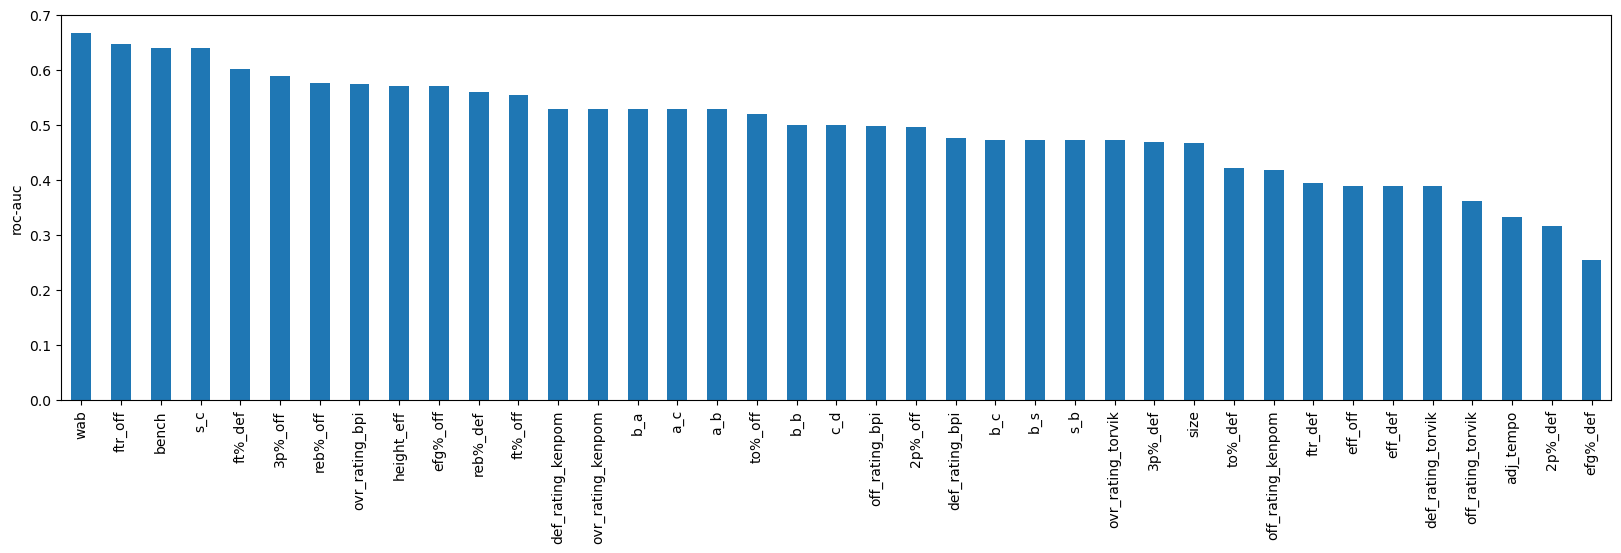

In [191]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [192]:
len(roc_values[roc_values > 0.5])

18

In [193]:
len(roc_values[roc_values > 0.6])

5

# X. Feature Selection

In [194]:
# The second weekend has a lot of randomness and it is easier to overfit than generalize.
model_df = df[[
 'game_id',
 'id',
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'high_bracket_score',
 'low_bracket_score',
 'point_diff',
 'point_total',
 'win',
 'ovr_rating_bpi', 
 'ovr_rating_torvik', 
 'wab', 
 'off_rating_bpi',
 'off_rating_kenpom', 
 'off_rating_torvik', 
 'def_rating_bpi', #Extra
 'ftr_off', #Extra
 'efg%_def', 
 '2p%_def',
 'ft%_def', #Extra
 'size', #Extra
 'bench', 
 'adj_tempo',
 's_c', #Extra
 'a_b
]]
model_df.to_csv('model_features_weekend2_classic_historical.csv')

SyntaxError: EOL while scanning string literal (1569221043.py, line 32)